In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from IPython.display import clear_output, display

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

#from google.colab import drive
#drive.mount('/content/drive')

from pathlib import Path
#dirpath_root = Path('/content/drive/MyDrive/repo/pytorch_test')
dirpath_root = Path().resolve()

cpu


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors

def plot_variable_line(x, y, color='blue', alpha=None, ax=None, linewidth=2, mode='opacity'):
    """
    Plot a line with per-segment styling driven by `alpha`.

    mode:
      - 'opacity'      -> alpha controls transparency (0 = fully transparent).
      - 'blend_white'  -> alpha blends color -> white (opaque paint).
    """
    x = np.ravel(np.asarray(x))
    y = np.ravel(np.asarray(y))
    if x.shape != y.shape:
        raise ValueError(f"x and y must have same shape, got {x.shape} vs {y.shape}")

    if alpha is None:
        alpha = np.ones_like(x, dtype=float)
    else:
        alpha = np.asarray(alpha, dtype=float)
        if alpha.ndim == 0:
            alpha = np.full_like(x, float(alpha))
        elif alpha.shape != x.shape:
            raise ValueError(f"alpha must be scalar or same shape as x, got {alpha.shape}")
    alpha = np.clip(alpha, 0, 1)

    # Build segments
    points = np.column_stack([x, y]).reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    a = alpha[:-1]  # one value per segment

    base_rgb = np.array(mcolors.to_rgb(color))
    colors = np.empty((len(segments), 4), float)

    if mode == 'opacity':
        # Keep RGB constant; vary only alpha channel (true transparency)
        colors[:, :3] = base_rgb
        colors[:, 3] = a
    elif mode == 'blend_white':
        # Previous behavior: blend toward white, opaque paint
        colors[:, :3] = (1 - a)[:, None] * 1.0 + a[:, None] * base_rgb
        colors[:, 3] = 1.0
    else:
        raise ValueError("mode must be 'opacity' or 'blend_white'")

    lc = LineCollection(segments, colors=colors, linewidth=linewidth)
    ax = ax or plt.gca()
    ax.add_collection(lc)
    ax.autoscale()
    return lc

def test_plot_variable_line():
    x = np.linspace(0, 3, 200)
    y = np.sin(x)
    p = 1 / x
    plt.figure()
    plot_variable_line(x, y, 'b', alpha=p)
#test_plot_variable_line()

In [26]:
from copy import deepcopy
from dataclasses import asdict, dataclass, field
from typing import Literal


def sample_with_pdf(npts, xlim, p):
    ngen = 0
    x = []
    nbatch = npts
    while ngen < npts:
        x_ = np.random.uniform(xlim[0], xlim[1], nbatch)
        r_ = np.random.uniform(0, 1, nbatch)
        x_ = x_[r_ < p(x_)]
        x.append(x_)
        ngen += len(x_)
    x = np.concatenate(x)[:npts]
    return x

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def make_func(f_type: str, par: dict):
    par = deepcopy(par)
    if f_type == 'const':
        f = lambda x: np.full_like(np.asarray(x), par['c'], dtype=float)
    elif f_type == 'sigmoid':
        f = lambda x: par['c'] + par['a'] * sigmoid(par['k'] * (np.asarray(x) - par['x0']))
    else:
        raise ValueError(f'Unknown function type: {f_type}')
    
    xmin = par['xmin'] if 'xmin' in par else -np.inf
    xmax = par['xmax'] if 'xmax' in par else np.inf
    return lambda x: f(x) * ((np.asarray(x) >= xmin) & (np.asarray(x) <= xmax))
    

@dataclass
class Branch:
    px_type: str
    px_par: dict
    fy_type: str
    fy_par: dict

    def generate_points(self, npts):
        fp = make_func(self.px_type, self.px_par)
        xlim = self.px_par['xmin'], self.px_par['xmax']
        x = sample_with_pdf(npts, xlim, fp)
        fy = make_func(self.fy_type, self.fy_par)
        y = fy(x)
        return x, y


class DataSet:
    vars: dict
    state: Literal['np', 'torch']

    def __init__(self,
                 vars: dict = None,
                 state: Literal['np', 'torch'] = 'np'):
        self.vars = vars or {}
        self.state = state
    
    def __getitem__(self, key):
        return self.vars[key]
    def __setitem__(self, key, value):
        self.vars[key] = value
    def __len__(self):
        return len(self.vars)
    def __iter__(self):
        return iter(self.vars)


class MultiBranchGenerator:
    branches: list[Branch]
    
    def __init__(self):
        self.branches = []

    def add_branch(self, *args, **kwargs):
        self.branches.append(Branch(*args, **kwargs))

    def generate_points(self, npts) -> DataSet:
        # Num. points in each branch
        nbr = len(self.branches)
        npts_br = np.ones(nbr) * int(npts / nbr)
        npts_br[-1] = npts - npts_br[:-1].sum()
        # Generate branch points
        x, y, b = [], [], []
        for n, br, npts_ in enumerate(zip(self.branches, npts_br)):
            x_, y_ = br.generate_points(npts_)
            b_ = np.full(npts_, n)
            x.append(x_); y.append(y_); b.append(b_)
        return DataSet(vars={
            'x': np.concatenate(x),
            'y': np.concatenate(y),
            'b': np.concatenate(b).astype(int)
        })
    
    def plot_branches(self, x):
        colors = ['b', 'r', 'g', 'm', 'k']
        for n, br in enumerate(self.branches):
            fy = make_func(br.fy_type, br.fy_par)
            fp = make_func(br.px_type, br.px_par)
            plot_variable_line(x, fy(x), colors[n % len(colors)], alpha=fp(x))
    
    def get_param_dict(self) -> dict:
        par = {}
        for n, br in enumerate(self.branches):
            par[n] = asdict(br)
        return par   


In [ ]:
#def test_branch_gen():

mb = MultiBranchGenerator()
mb.add_branch(px_type='const', px_par={'c': 1},
              fy_type='const', fy_par={'c': -0.5})
mb.add_branch(
    #px_type='const', px_par={'c': 1},
    px_type='sigmoid', px_par={'c': 0, 'a': 1, 'x0': 5, 'k': -1, 'xmin': -1.5}, 
    fy_type='sigmoid', fy_par={'c': -0.5, 'a': 1.5, 'x0': 2, 'k': 2}
)

plt.figure()
x = np.linspace(-5, 10, 200)
mb.plot_branches(x)     

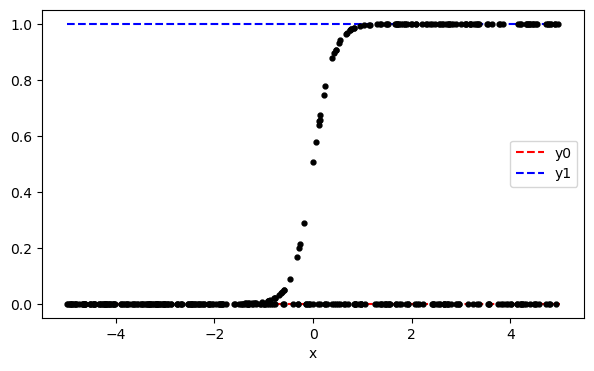

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def test_sample_with_pdf():
    p = sigmoid
    xlim = (-10, 10)
    xs = sample_with_pdf(5000, xlim, p)
    bins = np.linspace(xlim[0], xlim[1], 50)
    h, _ = np.histogram(xs, bins, density=True)
    x_ = np.linspace(xlim[0], xlim[1], 500)
    p_ = p(x_)
    p_ = p_ / np.sum(p_) / (x_[1] - x_[0])

    plt.figure()
    plt.plot(bins[:-1], h)
    plt.plot(x_, p_)
    plt.show()

K = 2
yK0 = [0, 1]
xc = 1.5
kc = 0.05

xmax, nx = 5, 200
x = np.linspace(-xmax, xmax, nx)
yK = [yK0[n] * np.ones(nx) for n in range(K)]
xc_ = [xc, -xc]
kc_ = [-kc, kc]
pK = [lambda x_, n=n: sigmoid((x_ - xc_[n]) / kc_[n]) for n in range(K)]

def gen_sample_K(npts, xlim, n):
    xsK = sample_with_pdf(npts, xlim, pK[n])
    ysK = yK0[n] * np.ones(npts)
    return xsK, ysK

def gen_sample_K_branch(npts, xlim, n):
    xsK = np.random.uniform(xlim[0], xlim[1], npts)
    ysK = yK0[n] * sigmoid(xsK * 5)
    return xsK, ysK

def gen_sample(npts, xlim, merge=True):
    xs, ys = [], []
    for n in range(K):
        #xs_, ys_ = gen_sample_K(npts, xlim, n)
        xs_, ys_ = gen_sample_K_branch(npts, xlim, n)
        xs.append(xs_)
        ys.append(ys_)
    if merge:
        xs = np.concatenate(xs)
        ys = np.concatenate(ys)
    return xs, ys

# Generate the sample
npts = 200
#xsK, ysK = gen_sample(npts, (-xmax, xmax), merge=False)
xs, ys = gen_sample(npts, (-xmax, xmax))
    
#print(samples)

plt.figure(figsize=(7, 4))
cols = ['r', 'b']
for n in range(K):
    #plt.plot(x, pK[n](x), cols[n], label=f'p{n}')
    plt.plot(x, yK[n], cols[n] + '--', label=f'y{n}')
    #plt.plot(xsK[n], ysK[n], cols[n] + '.', markersize=7)
plt.plot(xs, ys, 'k.', markersize=7)
#plt.plot(x, np.zeros(nx), 'k--')
#plt.plot(x, np.ones(nx), 'k--')
plt.xlabel('x')
plt.legend()
plt.show()


In [15]:
class MLP(nn.Module):
    def __init__(self, d_in, d_hidden, d_out, n_layers=2, act=nn.GELU):
        super().__init__()
        layers = [nn.Linear(d_in, d_hidden), act()]
        for _ in range(n_layers - 1):
            layers += [nn.Linear(d_hidden, d_hidden), act()]
        layers += [nn.Linear(d_hidden, d_out)]
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

class GatedKHeads(nn.Module):
    def __init__(self, d_in, d_out, hidden=128,
                 trunk_layers=2, K=2, ):
        super().__init__()
        self.K = K
        self.trunk = MLP(d_in, hidden, hidden, n_layers=trunk_layers)
        # K expert heads
        self.experts = nn.ModuleList(
            [MLP(hidden, hidden, d_out, n_layers=1) for _ in range(K)])
        # Gate -> logits for K heads
        self.gate = MLP(hidden, hidden, K, n_layers=1)

    def forward(self, x):
        z = self.trunk(x)
        ys = torch.stack(
            [h(z) for h in self.experts], dim=1)   # (B, K, d_out)
        pi_logits = self.gate(z)                   # (B, K)
        #pi = F.softmax(pi_logits, dim=-1)          # (B, K)
        pi = F.sigmoid(pi_logits)
        return ys, pi, pi_logits

mse = torch.nn.MSELoss(reduction='none')

def loss_kheads_old(
        yK, pi, logits, y_true,
        alpha=0.05, beta=0.0, lam=0.05, margin=0.3):
    
    # Prediction error
    # yK: (B,K,d_out), pi: (B,K), r_true: (B,d_out)
    dK = ((yK - y_true.unsqueeze(1))**2).mean(-1)             # (B,K)
    L_fit = (pi * dK).sum(dim=1).mean()

    # Load-balance (KL to uniform)
    pi_bar = pi.mean(dim=0)                                    # (K,)
    L_bal = (pi_bar * (pi_bar.clamp_min(1e-8) * yK.size(1)).log()).sum()

    # Hard gating CE (winner-take-all pseudo-label)
    if beta > 0:
        winners = dK.argmin(dim=1)
        L_ce = F.cross_entropy(logits, winners)
    else:
        L_ce = torch.zeros((), device=yK.device)

    # Conditional diversity (hinge on pairwise distance when gate is unsure)
    if yK.size(1) == 2:
        D = torch.norm(yK[:,0,:] - yK[:,1,:], dim=-1)          # (B,)
        conf = pi.max(dim=1).values                            # (B,)
        L_div = ((1 - conf) * F.relu(margin - D)**2).mean()
    else:
        # generic K>2: pairwise distances + average (omit for brevity)
        print("Diversity loss not implemented for K > 2, using zero loss.")
        L_div = torch.zeros((), device=yK.device)

    loss = L_fit + alpha * L_bal + beta * L_ce + lam * L_div
    return loss, {'fit': L_fit.detach(), 'bal': L_bal.detach(),
                  'ce': L_ce.detach(), 'div': L_div.detach()}

def kheads_top1_mse(yK, y_true):
    # Best head by true distance
    dK = mse(yK, y_true.unsqueeze(1)).mean(-1)   # (B, K)
    d_min = dK.min(dim=1).values   # (B)
    return d_min.mean()

def loss_kheads(yK, pi, pi_logits, y_true, gamma=1, tau=0.2, delta=None):
    dK = mse(yK, y_true.unsqueeze(1)).mean(-1)   # (B, K)
    dmin = dK.min(dim=1).values   # (B)
    head_loss = dmin.mean()
    with torch.no_grad():
        delta = dmin.median() if delta is None else delta
        piK_target = torch.sigmoid((delta - dK) / tau)   # (B, K)
    gate_loss = F.binary_cross_entropy_with_logits(
        pi_logits, piK_target)
    return head_loss + gamma * gate_loss

@torch.no_grad()
def kheads_eval_epoch(model, X, y, batch_size=1024, device='cuda'):
    model.eval()
    n = X.size(0)
    tot_loss = 0.0
    tot_top1 = 0.0
    bal = 0.0
    tot_gate_entropy = 0.0
    steps = 0
    for i in range(0, n, batch_size):
        xb = X[i : i + batch_size].to(device, non_blocking=True)
        yb = y[i : i + batch_size].to(device, non_blocking=True)
        yK, pi, _ = model(xb)
        # Report top-1 MSE (closest head) as intuitive metric
        tot_top1 += kheads_top1_mse(yK, yb).item()
        # Report gated MSE (the same objective as training)
        dK = ((yK - yb.unsqueeze(1))**2).mean(-1)
        tot_loss += (pi * dK).sum(dim=1).mean().item()
        # Gate balance
        pi_bar = pi.mean(dim=0)
        bal += (pi_bar * (pi_bar.clamp_min(1e-8) * yK.size(1)).log()).sum().item()
        # Gate usage entropy (higher ~ balanced)
        ent = -(pi.clamp_min(1e-8) * pi.clamp_min(1e-8).log()).sum(dim=1).mean().item()
        tot_gate_entropy += ent
        steps += 1
    return {'gated_mse': tot_loss / steps,
            'top1_mse': tot_top1 / steps,
            'gate_balance': bal / steps,
            'gate_entropy': tot_gate_entropy / steps}


In [27]:
x = torch.randint(0, 10, (5, 3))
print(x)
d, idx = x.min(dim=1)
print(d)
print(idx)

pi = torch.randn((5, 3))
print(pi)

pi0 = (idx.unsqueeze(1) == torch.arange(3)).float()
print(pi0)

pi_loss = torch.nn.functional.binary_cross_entropy_with_logits(
    pi, pi0, reduction='none').mean(dim=0)
print(pi_loss)

tensor([[4, 7, 5],
        [2, 5, 3],
        [3, 2, 4],
        [4, 1, 3],
        [8, 5, 4]])
tensor([4, 2, 2, 1, 4])
tensor([0, 0, 1, 1, 2])
tensor([[ 0.2218,  2.4158,  1.0405],
        [-0.6193, -0.0549,  1.3642],
        [ 1.5527,  1.6418, -1.1319],
        [-0.4726, -0.9387, -0.9275],
        [ 0.0432,  1.1680,  1.1376]])
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([0.9165, 1.2104, 0.7651])


In [5]:
class ProgressTracker:
    def __init__(self):
        self.data = {}
        self.plots = {}
        self.xdata_name = None
        self._init_axes()
    
    def _init_axes(self):
        self.fig, self.ax1 = plt.subplots()
        self.ax2 = self.ax1.twinx()
    
    def _get_ax(self, ax):
        if ax == 'y1':
            return self.ax1
        elif ax == 'y2':
            return self.ax2
    
    """ def _get_color(self, ax):
        if ax == 'y1':
            cols = plt.cm.tab10.colors
        elif ax == 'y2':
            cols = plt.cm.Set2.colors
        return cols[len(self._get_ax(ax).lines) % len(cols)] """
    
    def _get_color(self):
        cols = plt.cm.tab10.colors
        return cols[(len(self.data) - 2) % len(cols)]
    
    def add_data(self, name, ax):
        self.data[name] = []
        if ax == 'x':
            self.xdata_name = name
        elif ax in ('y1', 'y2'):
            (self.plots[name],) = (self._get_ax(ax).plot(
                [], [], label=name, color=self._get_color()))
        else:
            raise ValueError("ax must be 'x', 'y1', or 'y2'")
    
    def append(self, name, vals):
        if np.isscalar(vals):
            vals = [vals]
        self.data[name] += list(vals)
    
    def plot(self):
        x = self.data[self.xdata_name]
        for name, p in self.plots.items():
            y = self.data[name]
            p.set_data(x, y)
        for ax in (self.ax1, self.ax2):
            ax.relim()
            ax.autoscale_view()
        self.ax1.legend(loc='upper left')
        self.ax2.legend(loc='upper right')
        #self.fig.show()

def test_progress_tracker():
    pt = ProgressTracker()
    pt.add_data('data0', 'x')
    pt.add_data('data11', 'y1')
    pt.add_data('data12', 'y1')
    pt.add_data('data21', 'y2')
    pt.add_data('data22', 'y2')

    x = np.linspace(0, 3, 100)
    pt.append('data0', x)
    pt.append('data11', np.sin(x))
    pt.append('data12', np.cos(x))
    pt.append('data21', 0.1 * np.sin(2 * x))
    pt.append('data22', 0.1 * np.cos(2 * x))
    pt.plot()
    plt.show()

#test_progress_tracker()

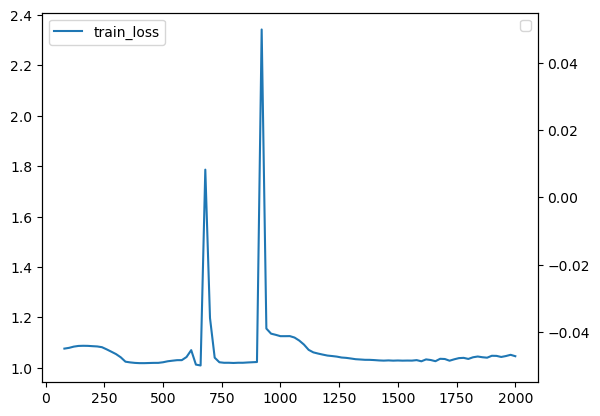

In [39]:
TORCH_SEED = 1
SPLIT_SEED = 0

HIDDEN_SZ = 16
NLAYERS_HID = 1
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 2000
PRINT_EVERY = 20

ALPHA = 2   # head balance
BETA = 0
LAM = 1     # head diversity
MARGIN = 0.3

#torch.manual_seed(TORCH_SEED)

# Generate the sample
npts = 200
Xs, ys = gen_sample(npts, (-xmax, xmax))
X = torch.from_numpy(Xs).type(torch.float).unsqueeze(1)
y = torch.from_numpy(ys).type(torch.float).unsqueeze(1)
print(X.shape, y.shape)

# Define the model
n_feat = X.shape[1]
n_out = y.shape[1]
#model = MLP(n_feat, HIDDEN_SZ, n_out, NLAYERS_HID)
model = GatedKHeads(n_feat, n_out, HIDDEN_SZ, NLAYERS_HID, K=2)
model = model.to(device)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SPLIT_SEED
)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Loader
dataset = torch.utils.data.TensorDataset(X_train, y_train)
loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# Loss function
#loss_fn = nn.MSELoss()
#loss_fn = lambda pred, y: loss_kheads(
#    pred[0], pred[1], pred[2], y, ALPHA, BETA, LAM, MARGIN)[0]
#loss_fn = lambda pred, y: kheads_top1_mse(pred[0], y)
loss_fn = lambda pred, y: loss_kheads(*pred, y, gamma=2, tau=0.02, delta=1e-2)

# Progress tracker
pt = ProgressTracker()
pt.add_data('epoch', 'x')
#pt.add_data('gated_mse', 'y1')
#pt.add_data('top1_mse', 'y1')
pt.add_data('train_loss', 'y1')
#pt.add_data('gate_bal', 'y2')
#pt.add_data('gate_ent', 'y2')

for epoch in range(1, EPOCHS + 1):
    model.train()

    train_loss = 0
    n_seen = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        n_seen += xb.size(0)

    train_loss /= n_seen

    #if epoch % PRINT_EVERY == 0 or epoch == 1:
    if (epoch % PRINT_EVERY == 0) and (epoch > 70):
        # Testing
        #model.eval()   # switch to evaluation mode
        #with torch.inference_mode():
        #    pred = model(X_train)
        #    train_loss = loss_fn(pred, y_train).item()

        #res = kheads_eval_epoch(model, X_train, y_train, device=device)
        pt.append('epoch', epoch)
        #pt.append('gated_mse', res['gated_mse'])
        #pt.append('top1_mse', res['top1_mse'])
        pt.append('train_loss', train_loss)
        #pt.append('gate_bal', res['gate_balance'])
        #pt.append('gate_ent', res['gate_entropy'])
        pt.plot()        
        clear_output(wait=True)
        display(pt.fig)

plt.close(pt.fig)

In [207]:
train_loss

array(1.5019798, dtype=float32)

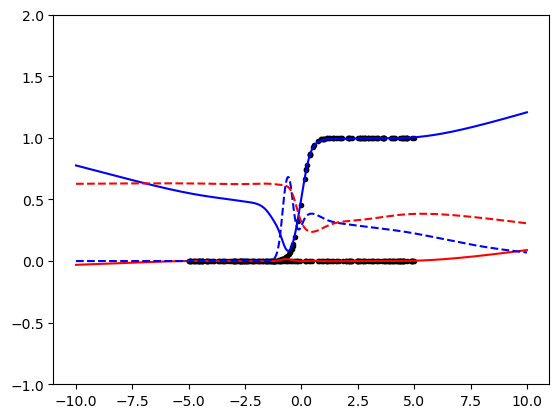

In [40]:
def eval_model(model, x: np.ndarray):
    x_tens = torch.from_numpy(x).float().unsqueeze(1)
    model.eval()
    with torch.no_grad():
        #y = model(x_tens).to('cpu').numpy()
        yK, pi, pi_logits = model(x_tens)
        yK = yK.to('cpu').numpy()
        pi = pi.to('cpu').numpy()
    return yK, pi, pi_logits

x_ = np.linspace(-10, 10, 1000)
yK_, pi_, pi_logits_ = eval_model(model, x_)

plt.figure()
plt.plot(X_train.to('cpu').numpy(),
         y_train.to('cpu').numpy(), 'k.')
plt.plot(x_, yK_[:, 0], 'b')
plt.plot(x_, yK_[:, 1], 'r')
plt.plot(x_, pi_[:, 0], 'b--')
plt.plot(x_, pi_[:, 1], 'r--')
plt.ylim(-1, 2)
plt.show()

In [11]:
import os

dirpath_out = dirpath_root / 'model' / 'rates_2pop_1mat' / fname
os.makedirs(dirpath_out, exist_ok=True)

# Save the trained model
fname_model = (
    f'nhid_{NLAYERS_HID}_szhid_{HIDDEN_SZ}_'
    f'batch_{BATCH_SIZE}_lr_{LR:.04f}_ep_{EPOCHS}_'
    f'alpha_{ALPHA}_beta_{BETA}_lam_{LAM}_marg_{MARGIN}_'
    f'split_{SPLIT_SEED}.pth'
)
fpath_model = dirpath_out / fname_model
torch.save(model.state_dict(), fpath_model)
print(f"Model saved to {fpath_model}")

Model saved to G:\Мой диск\repo\pytorch_test\model\rates_2pop_1mat\rates_ws_1_nw_100_wsel_2_npts_5000_rmarg_0.01_seed_113\nhid_2_szhid_64_batch_128_lr_0.0010_ep_2000_alpha_0.5_beta_0.1_lam_0.0_marg_0.3_split_0.pth


In [12]:
res = {
    'train': {'Xtens': X_train, 'ytens': y_train},   # pytorch tensors
    'test': {'Xtens': X_test, 'ytens': y_test}
}

# Apply trained todel to the train and test sets
model.eval()
with torch.inference_mode():
    for _, res_ in res.items():
        res_['yK'], res_['pi'], _ = model(res_['Xtens'])

# Pytorch tensors to numpy
for _, res_ in res.items():
    res_['yK'] = res_['yK'].cpu().numpy()
    res_['pi'] = res_['pi'].cpu().numpy()
    res_['X'] = res_['Xtens'].cpu().numpy()
    res_['y'] = res_['ytens'].cpu().numpy()

In [20]:
# Calculate error
for name, res_ in res.items():
    y_, yK_ = res_['y'], res_['yK']
    #err = np.sqrt(np.sum((rr - y) ** 2, axis=-1))
    err = np.sqrt(np.sum((y_.reshape((-1, 1, 2)) - yK_) ** 2, axis=-1)).min(axis=1)
    res_['err'] = err
    print(f'{name}:\t', np.round(err[:10], 4))

#y = np.zeros_like(rr)
#mask = pi[:, 0] > pi[:, 1]
#y[mask, :] = yK[mask, 0, :]
#y[~mask, :] = yK[~mask, 1, :]

#res = np.concatenate((rr, y), axis=1)
#print(np.round(res[:10, :], 3))

train:	 [0.1664 0.3568 0.9125 0.3588 0.9255 0.2315 0.8614 0.054  0.1553 0.0673]
test:	 [0.8748 0.4767 4.1698 0.3787 0.0275 0.0848 1.9389 0.0531 0.1936 0.4729]


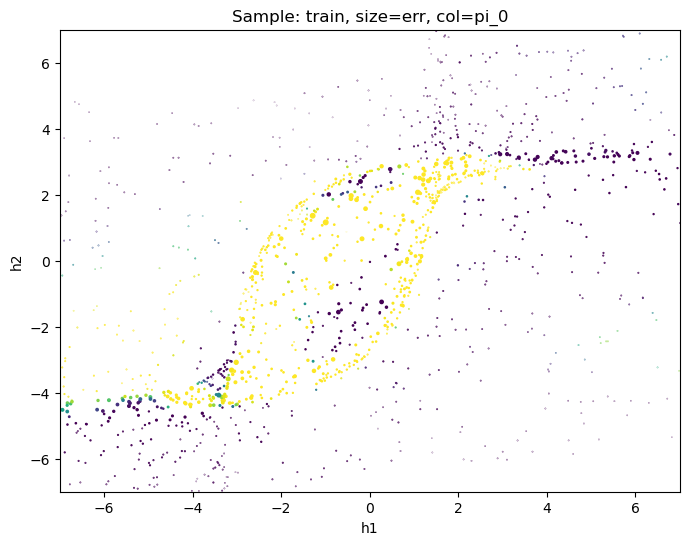

In [46]:
#pi_max = np.max(pi, axis=-1)

sample_name = 'train'
#sample_name = 'test'

res_ = res[sample_name]

#s = 1
s = res_['err']
#c = err
#s = pi_max * 5
#c = pi_max
#s = pi[:, 0] * 5
c = res_['pi'][:, 0]

plt.figure(figsize=(8, 6))
#plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 1)
#plt.scatter(y_train[:, 0], y_train[:, 1], s=s, c=c)
#plt.xlabel('r1')
#plt.ylabel('r2')
#plt.colorbar()
#plt.subplot(1, 2, 2)
plt.scatter(res_['X'][:, 0], res_['X'][:, 1], s=s, c=c)
plt.xlabel('h1')
plt.ylabel('h2')
m = 7
plt.xlim(-m, m)
plt.ylim(-m, m)
#plt.colorbar(label='pi_0')
plt.title(f'Sample: {sample_name}, size=err, col=pi_0')
plt.show()

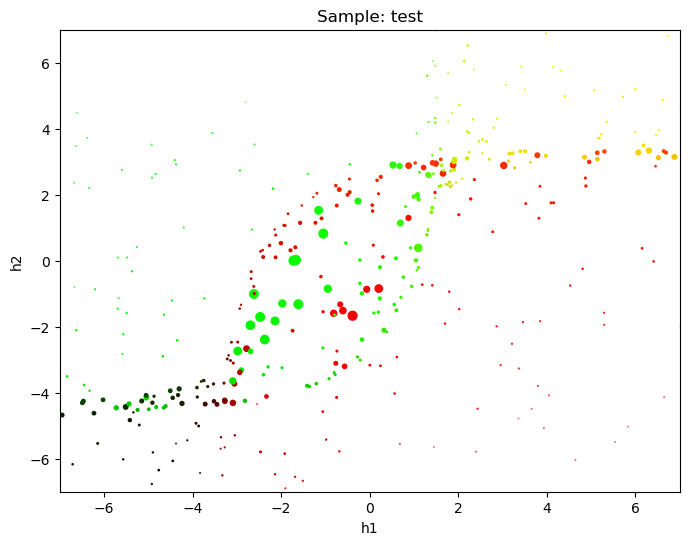

In [53]:
#sample_name = 'train'
sample_name = 'test'
res_ = res[sample_name]

cols = np.clip(res_['y'] / 10, 0, 1)
cols = np.hstack((cols, np.zeros((cols.shape[0], 1))))

#s = 2
s = res_['err'] * 3

plt.figure(figsize=(8, 6))
plt.scatter(res_['X'][:, 0], res_['X'][:, 1], s=s, c=cols)
plt.xlabel('h1')
plt.ylabel('h2')
m = 7
plt.xlim(-m, m)
plt.ylim(-m, m)
#plt.colorbar(label='pi_0')
plt.title(f'Sample: {sample_name}')
plt.show()